In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import numops
import par

In [66]:
H0 = c = 1.0
spec = [
    ('N', numba.int64),
    ('K', numba.int64),
    ('A', numba.float64[:]),
    ('H0', numba.float64),
    ('c', numba.float64),
    ('OmegaB0', numba.float64),
    ('OmegaC0', numba.float64),
    ('OmegaG0', numba.float64),
    ('OmegaN0', numba.float64),
    ('OmegaL0', numba.float64),
    ('OmegaM0', numba.float64),
    ('OmegaR0', numba.float64),
    ('OmegaD_tau0', numba.float64),
    ('OmegaB', numba.float64[:]),
    ('OmegaC', numba.float64[:]),
    ('OmegaG', numba.float64[:]),
    ('OmegaN', numba.float64[:]),
    ('OmegaM', numba.float64[:]),
    ('OmegaR', numba.float64[:]),
    ('OmegaL', numba.float64[:]),
    ('TAU', numba.float64[:]),   
    ('H', numba.float64[:]),
    ('OmegaD', numba.float64[:]),
    ('wD', numba.float64[:]),
    ('DwD', numba.float64[:]),
    ('cs2D', numba.float64[:,:]),
    ('deltaD0', numba.float64[:]),
    ('vD0', numba.float64[:])
]

#@numba.jitclass(spec)
class background(object):
    def __init__(self, A):
        self.N = len(A)
        self.K = 256
        
        self.A = A
        self.H0 = 1.0
        self.c = 1.0
        self.OmegaB0 = 0.04968
        self.OmegaC0 = 0.26754
        self.OmegaG0 = 5.50234e-5
        self.OmegaN0 = 3.74248e-5
        self.OmegaM0 = self.OmegaB0 + self.OmegaC0
        self.OmegaR0 = self.OmegaG0 + self.OmegaN0
        self.OmegaL0 = 1-(self.OmegaM0 + self.OmegaR0)
        self.OmegaB = self.OmegaB0 * A**-3
        self.OmegaC = self.OmegaC0 * A**-3
        self.OmegaG = self.OmegaB0 * A**-4
        self.OmegaN = self.OmegaC0 * A**-4
        self.OmegaM = self.OmegaC + self.OmegaB
        self.OmegaR = self.OmegaG + self.OmegaN   
        self.OmegaL = np.ones(self.N) * self.OmegaL0
        self.OmegaD_tau0 = 0
        
        self.OmegaD = np.zeros(self.N, dtype=np.float64)
        self.TAU = np.zeros(self.N, dtype=np.float64)
        self.H = np.zeros(self.N, dtype=np.float64)
        self.wD = np.zeros(self.N, dtype=np.float64)
        self.DwD = np.zeros(self.N, dtype=np.float64)
        self.cs2D = np.zeros((self.N,self.K))
        self.deltaD0 = np.zeros(self.K, dtype=np.float64)
        self.vD0 = np.zeros(self.K, dtype=np.float64)
        
        self.update_Omegas()
        self.update_H()
        self.update_TAU()
        
    
    def update_Omegas(self):
        self.OmegaB = self.OmegaB0 * self.A**-3
        self.OmegaC = self.OmegaC0 * self.A**-3
        self.OmegaG = self.OmegaB0 * self.A**-4
        self.OmegaN = self.OmegaN0 * self.A**-4
        self.OmegaM = self.OmegaC + self.OmegaB
        self.OmegaR = self.OmegaG + self.OmegaN
        self.OmegaL = np.ones(self.N) * self.OmegaL0
        
        self.OmegaD = np.zeros(self.N)
        s = -3*numops.trapz(self.A, (1+self.wD)/self.A)
        self.OmegaD = self.OmegaD_tau0* np.exp(s)

    def update_H(self):
        self.H = self.A *\
        self.H0 * np.sqrt(self.OmegaM+ self.OmegaR +  self.OmegaL + self.OmegaD)
        self.H = self.A *\
        self.H0 * np.sqrt(self.OmegaB + self.OmegaC+ self.OmegaG + self.OmegaN +  self.OmegaL)


    def update_TAU(self):
        A_early = np.linspace(1.e-7, self.A[0],100)
        tau_itgd = 1/(A_early**2* self.H0 * np.sqrt(
        self.OmegaM0*A_early**-3 + self.OmegaR0*A_early**-4 + self.OmegaL0)
        )
        tau0 = numops.trapz(A_early,tau_itgd)[-1]
        self.TAU =  tau0 + numops.trapz(self.A, 1/(self.A * self.H))
        
    def set_wD(self, wD_new):
        self.wD = wD_new
        self.DwD = np.roll(self.wD,1) - self.wD
        self.DwD = np.gradient(self.wD,self.TAU)
        self.update_Omegas()
        self.update_H()
        self.update_TAU()
        
    def set_OmegaD_tau0(self, OmegaD_tau0_new):
        self.OmegaD_tau0 = OmegaD_tau0_new
        self.update_Omegas()
        self.update_H()
        self.update_TAU()
        
    def set_OmegaB0(self, OmegaB0_new):
        self.OmegaB0 = OmegaB0_new
        self.OmegaM0 = self.OmegaB0 + self.OmegaC0
        self.OmegaL0 = 1-(self.OmegaM0 + self.OmegaR0)
        self.update_Omegas()
        self.update_H()
        self.update_TAU()
        
    def set_OmegaC0(self, OmegaC0_new):
        self.OmegaC0 = OmegaC0_new
        self.OmegaM0 = self.OmegaB0 + self.OmegaC0
        self.OmegaL0 = 1-(self.OmegaM0 + self.OmegaR0)
        self.update_Omegas()
        self.update_H()
        self.update_TAU()
       
    def set_OmegaG0(self, OmegaG0_new):
        self.OmegaG0 = OmegaG0_new
        self.OmegaR0 = self.OmegaG0 + self.OmegaN0
        self.OmegaL0 = 1-(self.OmegaM0 + self.OmegaR0)
        self.update_Omegas()
        self.update_H()
        self.update_TAU()

    def set_OmegaN0(self, OmegaN0_new):
        self.OmegaN0 = OmegaN0_new
        self.OmegaR0 = self.OmegaG0 + self.OmegaN0
        self.OmegaL0 = 1-(self.OmegaM0 + self.OmegaR0)
        self.update_Omegas()
        self.update_H()
        self.update_TAU()

    def set_cs2D(self, cs2D_new):
        self.cs2D = cs2D_new
        
    def set_deltaD0(self, deltaD0_new):
        self.deltaD0 = deltaD0_new
        
    def set_vD0(self, vD0_new):
        self.vD0 = vD0_new

In [67]:

#@numba.njit
def DY(i, Y, BG):
    dY = np.zeros((9, par.N_K_SOLVE))
    Phi = Y[0, :]
    deltaG = Y[1, :]
    vG = Y[2, :]
    deltac = Y[3, :]
    vC = Y[4, :]
    deltaN = Y[5, :]
    vN = Y[6, :]
    deltaD= Y[7, :]
    vD = Y[8, :]

    # compute background quantities for the current
    # time step.
    wDi = BG.wD[i]
    DwDi = BG.DwD[i]
    cs2Di = BG.cs2D[i,:]
    Hi = BG.H[i]
    H0 = BG.H0
    ai = BG.A[i]
    ybi = 1.68*ai*BG.OmegaB0/BG.OmegaR0
    OmegaBi = BG.OmegaB0 * ai**-3.
    OmegaCi = BG.OmegaC0 * ai**-3.
    OmegaGi = BG.OmegaG0 * ai**-4.
    OmegaNi = BG.OmegaN0 * ai**-4
    OmegaDi = BG.OmegaD[i]

    # compute the derivatives of the perturbations.
    DPhi = -Hi*Phi + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(OmegaGi*vG + OmegaNi*vN) + OmegaCi*vC + OmegaBi*vG +
         (1+wDi)*OmegaDi*vD)
    
    DdeltaG = -4./3.*k_solve*vG + 4*DPhi
    DvG = (-Hi * ybi*vG + k_solve*deltaG/3)/(
        4./3. + ybi) + k_solve*Phi

    Ddeltac = -k_solve*vC + 3*DPhi
    DvC = -Hi*vC + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4 + k_solve*Phi
    
    #print(len(k_solve), len(vD), len(DPhi))
    DdeltaD = -(1+wDi)*(k_solve*vD-3*DPhi) - 3*Hi*(cs2Di-wDi)*deltaD
    DvD = -Hi*(1-3*wDi)*vD - vD*DwDi/(1+wDi) + k_solve*deltaD*cs2Di/(1+wDi) + k_solve*Phi

    dY[0, :] = DPhi
    dY[1, :] = DdeltaG
    dY[2, :] = DvG
    dY[3, :] = Ddeltac
    dY[4, :] = DvC
    dY[5, :] = DdeltaN
    dY[6, :] = DvN
    dY[7, :] = DdeltaD
    dY[8, :] = DvD

    return dY

#@numba.njit
def solve(BG):
    # set initial conditions
    y0 = par.a0/par.a_eq
    Phi0 = np.ones(par.N_K_SOLVE)
    deltaG0 = -2*Phi0*(1 + 3*y0/16)
    vG0 = -k_solve/(BG.H[0]) * (deltaG0/4 + (2*k_solve**2 * (1 + y0)*Phi0) /
                              (9*(BG.H[0])**2 * (4./3. + y0)))
    deltaC0 = .75 * deltaG0
    vC0 = vG0
    deltaN0 = deltaG0
    vN0 = vG0
    OmegaC_in = BG.OmegaC[0]
    OmegaN_in = BG.OmegaN[0]
    OmegaD_in = BG.OmegaD[0]
    #deltaD0 = (OmegaC_in*deltaC0 + OmegaN_in*deltaN0)/OmegaD_in
    #vD0 = (OmegaC_in*vC0 + 4/3*OmegaN_in*vN0)/((1+1/3)*OmegaD_in)
    deltaD0 = BG.deltaD0
    vD0 = BG.vD0


    Y = np.zeros((len(BG.TAU)//2, 9, par.N_K_SOLVE))
    #Y[0, :, :] = np.array([Phi0, deltaG0, vG0, deltaC0, vC0, deltaN0, vN0, deltaD0, vD0])
    Y[0, 0, :] = Phi0
    Y[0, 1, :] = deltaG0
    Y[0, 2, :] = vG0
    Y[0, 3, :] = deltaC0
    Y[0, 4, :] = vC0
    Y[0, 5, :] = deltaN0
    Y[0, 6, :] = vN0
    Y[0, 7, :] = deltaD0
    Y[0, 8, :] = vD0
    
    # RK4 implementation
    for i in range(BG.N//2-1):
        ss = BG.TAU[2*i+2] - BG.TAU[2*i]
        k1 = ss*DY(2*i, Y[i, :, :], BG)
        k2 = ss*DY(2*i+1, Y[i, :, :]+k1/2, BG)
        k3 = ss*DY(2*i+1, Y[i, :, :]+k2/2, BG)
        k4 = ss*DY(2*i+2, Y[i, :, :]+k3, BG)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

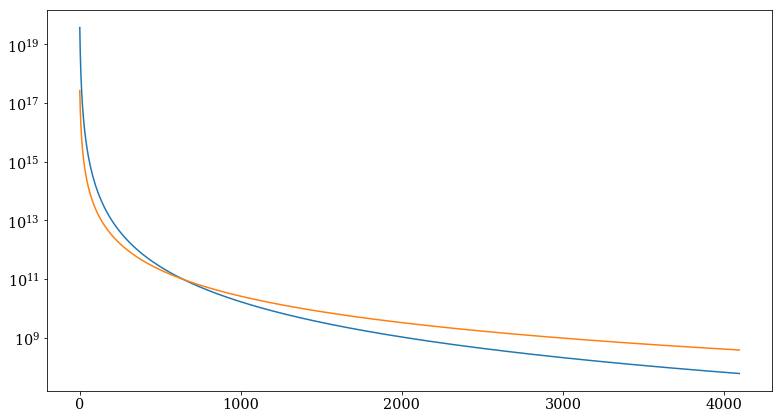

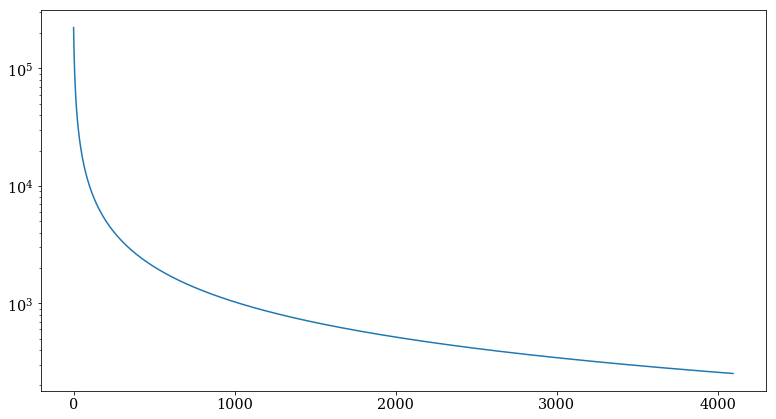

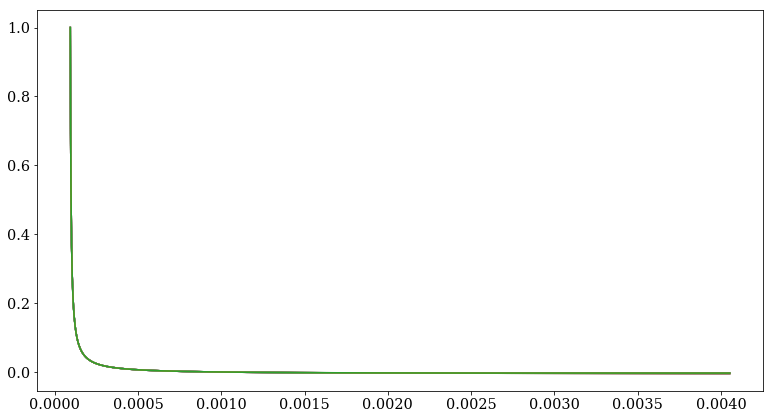

'\n\nY2 = solve(BG2)\nTAU2 = BG2.TAU[::2]\nplt.plot(TAU_out,Y[:,0,::20])\nplt.plot(TAU2,Y2[:,0,::20])\nplt.show()\n\n#plt.plot(TAU_out,Y[:,0,::20])\nplt.plot(TAU2,Y2[:,0,::20])\nplt.show()\n'

In [70]:
plt.rcParams.update(par.plot_params)

A = np.linspace(par.a0, par.a_rec, par.N_T_SOLVE)
k_solve = np.linspace(1, 1000, 256)
BG1 = background(A)
BG1.set_wD(np.zeros(BG1.N))

plt.semilogy()
plt.plot(BG1.OmegaN)
plt.plot(BG1.OmegaC)
plt.show()

Y = solve(BG1)
TAU_out = BG1.TAU[::2]
Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC = Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN = Y[:, 6, :].T




OmegaB = BG1.OmegaB[::2]
OmegaC = BG1.OmegaC[::2]
OmegaG = BG1.OmegaG[::2]
OmegaN = BG1.OmegaN[::2]
OmegaD = OmegaC + OmegaN

wD = OmegaN/(3*(OmegaN + OmegaC))
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = ((deltaN*OmegaN*1/3)/(deltaD*OmegaD)).T
#BG2.set_deltaD0((OmegaC[0]*deltaC[0,:] + OmegaN[0]*deltaN[0])/OmegaD[0])
#BG2.set_vD0((OmegaC[0]*vC[0,:] + 4/3*OmegaN[0]*vN[0,:])/((1+wD[0])*OmegaD[0]))


plt.semilogy(BG1.H)
plt.show()

plt.plot(BG1.TAU[::2], Y[:,0,::20])
#plt.plot(BG1.TAU[::2], Y[:,7,::20])
plt.show()


"""

Y2 = solve(BG2)
TAU2 = BG2.TAU[::2]
plt.plot(TAU_out,Y[:,0,::20])
plt.plot(TAU2,Y2[:,0,::20])
plt.show()

#plt.plot(TAU_out,Y[:,0,::20])
plt.plot(TAU2,Y2[:,0,::20])
plt.show()
"""